In [11]:
import dask.array as ds
import dask
import os
from satpy import Scene, find_files_and_readers
from pyresample.geometry import AreaDefinition
import xarray as xarray
import yaml

In [12]:
from satpy.utils import check_satpy
check_satpy()

Readers


[DEBUG: 2024-04-29 13:41:10 : h5py._conv] Creating converter from 7 to 5
[DEBUG: 2024-04-29 13:41:10 : h5py._conv] Creating converter from 5 to 7
[DEBUG: 2024-04-29 13:41:10 : h5py._conv] Creating converter from 7 to 5
[DEBUG: 2024-04-29 13:41:10 : h5py._conv] Creating converter from 5 to 7


abi_l1b:  ok
abi_l1b_scmi:  ok
abi_l2_nc:  ok
acspo:  ok
agri_fy4a_l1:  ok
agri_fy4b_l1:  ok
ahi_hrit:  ok
ahi_hsd:  ok
ahi_l1b_gridded_bin:  ok
ahi_l2_nc:  ok
ami_l1b:  ok
amsr2_l1b:  ok
amsr2_l2:  ok
amsr2_l2_gaasp:  ok
amsub_l1c_aapp:  ok
ascat_l2_soilmoisture_bufr:  cannot find module 'satpy.readers.ascat_l2_soilmoisture_bufr' (('Missing eccodes-python and/or eccodes C-library installation. Use conda to install eccodes.\n           Error: ', ModuleNotFoundError("No module named 'eccodes'")))
atms_l1b_nc:  ok
atms_sdr_hdf5:  ok
avhrr_l1b_aapp:  ok
avhrr_l1b_eps:  ok
avhrr_l1b_gaclac:  cannot find module 'satpy.readers.avhrr_l1b_gaclac' (No module named 'pygac')
avhrr_l1b_hrpt:  ok
avhrr_l1c_eum_gac_fdr_nc:  ok
caliop_l2_cloud:  cannot find module 'satpy.readers.caliop_l2_cloud' (No module named 'pyhdf')
clavrx:  cannot find module 'satpy.readers.clavrx' (No module named 'pyhdf')
cmsaf-claas2_l2_nc:  ok
electrol_hrit:  ok
epic_l1b_h5:  ok
fci_l1c_nc:  ok
fci_l2_nc:  ok
generic_image:

In [13]:
from satpy.utils import debug_on
debug_on()

In [14]:
os.environ['SATPY_DASK_CHUNK_SIZE'] = '256'
dask.config.set(num_workers=4)

In [15]:
# TODO Modularize
with open('../../config/satvis.yaml', 'r') as f:
    config = yaml.safe_load(f)

dir_dict = config['data_directories']
data_dir = dir_dict['sentinel2']

print(data_dir)

C:\Arbetsmapp\ALGOTL


In [16]:
algotltest = AreaDefinition(
    area_id="algotltest",
    description="ALGOTL area around Gotland",
    proj_id="stere",
    projection={"proj": "stere", "lat_0": 57.435, "lon_0": 18.674999999999997},
    width=664,
    height=634,
    area_extent=(-95043.345303, -98594.030733, 95043.345303, 100717.352397),
)

# algotlTest:
#   description: algotlTest
#   projection:
#     proj: stere
#     ellps: WGS84
#     lat_0: 57.435
#     lon_0: 18.674999999999997
#   shape:
#     height: 66
#     width: 63
#   area_extent:
#     lower_left_xy: [-95043.345303, -98594.030733]
#     upper_right_xy: [95043.345303, 100717.352397]

In [17]:
files = find_files_and_readers(base_dir='.', reader='msi_safe')
scn = Scene(filenames=files)

[DEBUG: 2024-04-29 13:41:16 : satpy.readers.yaml_reader] Reading ('C:\\Users\\k000851\\AppData\\Local\\miniforge3\\envs\\ALGOTLvisTest\\Lib\\site-packages\\satpy\\etc\\readers\\msi_safe.yaml',)
[DEBUG: 2024-04-29 13:41:16 : satpy.readers.yaml_reader] Reading ('C:\\Users\\k000851\\AppData\\Local\\miniforge3\\envs\\ALGOTLvisTest\\Lib\\site-packages\\satpy\\etc\\readers\\msi_safe.yaml',)
[DEBUG: 2024-04-29 13:41:17 : satpy.readers.yaml_reader] Assigning to msi_safe: ['.\\S2A_MSIL1C_20220627T100611_N0400_R022_T33VXD_20220627T134958.SAFE\\GRANULE\\L1C_T33VXD_A036627_20220627T100933\\IMG_DATA\\T33VXD_20220627T100611_B09.jp2', '.\\S2A_MSIL1C_20220627T100611_N0400_R022_T33VXD_20220627T134958.SAFE\\GRANULE\\L1C_T33VXD_A036627_20220627T100933\\IMG_DATA\\T33VXD_20220627T100611_B11.jp2', '.\\S2A_MSIL1C_20220627T100611_N0400_R022_T33VXD_20220627T134958.SAFE\\GRANULE\\L1C_T33VXD_A036627_20220627T100933\\IMG_DATA\\T33VXD_20220627T100611_B8A.jp2', '.\\S2A_MSIL1C_20220627T100611_N0400_R022_T33VXC_20220

In [18]:
scn.available_composite_names()

['cloud_phase',
 'cloud_phase_raw',
 'day_essl_colorized_low_level_moisture',
 'day_essl_low_level_moisture',
 'essl_colorized_low_level_moisture',
 'essl_low_level_moisture',
 'natural_color',
 'true_color',
 'true_color_desert',
 'true_color_land',
 'true_color_marine_clean',
 'true_color_marine_tropical',
 'true_color_raw']

**With one file in Scene (S2A_MSIL1C_20220627T100611_N0400_R022_T33VXD_20220627T134958.SAFE)**

In [10]:
composite = 'true_color'
scn.load([composite])

[DEBUG: 2024-04-29 13:05:07 : satpy.readers.msi_safe] Reading B03.
[DEBUG: 2024-04-29 13:05:07 : rasterio.session] Could not import boto3, continuing with reduced functionality.
[DEBUG: 2024-04-29 13:05:07 : rasterio.env] Entering env context: <rasterio.env.Env object at 0x000002114FBC5F50>
[DEBUG: 2024-04-29 13:05:07 : rasterio.env] Starting outermost env
[DEBUG: 2024-04-29 13:05:07 : rasterio.env] No GDAL environment exists
[DEBUG: 2024-04-29 13:05:07 : rasterio.env] New GDAL environment <rasterio._env.GDALEnv object at 0x000002114F884D90> created
[DEBUG: 2024-04-29 13:05:07 : rasterio._filepath] Installing FilePath filesystem handler plugin...
[DEBUG: 2024-04-29 13:05:07 : rasterio._env] GDAL_DATA found in environment.
[DEBUG: 2024-04-29 13:05:07 : rasterio._env] PROJ_DATA found in environment.
[DEBUG: 2024-04-29 13:05:07 : rasterio._env] Started GDALEnv: self=<rasterio._env.GDALEnv object at 0x000002114F884D90>.
[DEBUG: 2024-04-29 13:05:07 : rasterio.env] Entered env context: <rast

In [13]:
lr_scn = scn.resample(algotltest, resampler='nearest')

[DEBUG: 2024-04-29 13:08:16 : satpy.scene] Resampling DataID(name='true_color', resolution=10)
[DEBUG: 2024-04-29 13:08:20 : satpy.resample] Computing kd-tree parameters
[DEBUG: 2024-04-29 13:08:20 : satpy.resample] Resampling where-a8553994382d14203534d3891c445b29


[DEBUG: 2024-04-29 13:08:26 : satpy.writers] Adding enhancement configuration from file: C:\Users\k000851\AppData\Local\miniforge3\envs\ALGOTLvisTest\Lib\site-packages\satpy\etc\enhancements\generic.yaml
[DEBUG: 2024-04-29 13:08:26 : satpy.writers] Data for DataID(name='true_color', resolution=10) will be enhanced with options:
	[{'name': 'cira_stretch', 'method': <function cira_stretch at 0x0000021151F81B20>}]
[DEBUG: 2024-04-29 13:08:26 : satpy.enhancements] Applying the cira-stretch
C:\Users\k000851\AppData\Local\miniforge3\envs\ALGOTLvisTest\Lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
[DEBUG: 2024-04-29 13:08:39 : rasterio._io] Output nodata value read from file: None
[DEBUG: 2024-04-29 13:08:39 : rasterio._io] Output nodata values: [None]
[DEBUG: 2024-04-29 13:08:39 : rasterio._io] all_valid: True
[DEBUG: 2024-04-29 13:08:39 : rasterio._io] mask_flags: ([<MaskFlags.all_valid: 1>],)
[DE

[DEBUG: 2024-04-29 13:08:49 : rasterio._io] Output nodata value read from file: None
[DEBUG: 2024-04-29 13:08:49 : rasterio._io] Output nodata values: [None]
[DEBUG: 2024-04-29 13:08:49 : rasterio._io] all_valid: True
[DEBUG: 2024-04-29 13:08:49 : rasterio._io] mask_flags: ([<MaskFlags.all_valid: 1>],)
[DEBUG: 2024-04-29 13:08:49 : rasterio._io] Jump straight to _read()
[DEBUG: 2024-04-29 13:08:49 : rasterio._io] Window: Window(col_off=0, row_off=8192, width=4096, height=2788)
[DEBUG: 2024-04-29 13:08:49 : rasterio._io] IO window xoff=0.0 yoff=8192.0 width=4096.0 height=2788.0
[DEBUG: 2024-04-29 13:09:11 : rasterio._io] Output nodata value read from file: None
[DEBUG: 2024-04-29 13:09:11 : rasterio._io] Output nodata values: [None]
[DEBUG: 2024-04-29 13:09:11 : rasterio._io] all_valid: True
[DEBUG: 2024-04-29 13:09:11 : rasterio._io] mask_flags: ([<MaskFlags.all_valid: 1>],)
[DEBUG: 2024-04-29 13:09:11 : rasterio._io] Jump straight to _read()
[DEBUG: 2024-04-29 13:09:11 : rasterio._io]

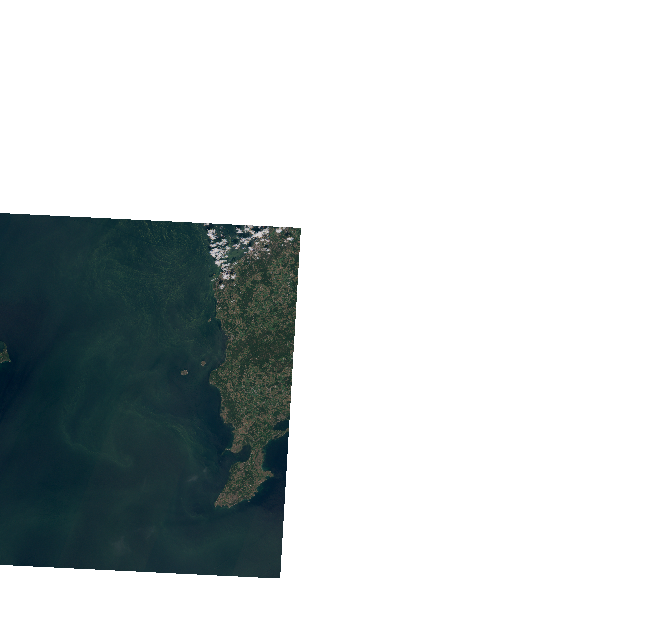

In [14]:
lr_scn.show(composite)

With two files in Scene (
    S2A_MSIL1C_20220627T100611_N0400_R022_T33VXD_20220627T134958.SAFE,
    S2A_MSIL1C_20220627T100611_N0400_R022_T34VDH_20220627T134958.SAFE)

In [17]:
composite = 'true_color'
scn.load([composite])

[DEBUG: 2024-04-29 13:11:10 : satpy.readers.yaml_reader] No coordinates found for DataID(name='solar_zenith_angle', resolution=10, modifiers=())
[DEBUG: 2024-04-29 13:11:10 : satpy.readers.msi_safe] Reading B03.
[DEBUG: 2024-04-29 13:11:10 : rasterio.env] Entering env context: <rasterio.env.Env object at 0x00000211025D3910>
[DEBUG: 2024-04-29 13:11:10 : rasterio.env] Starting outermost env
[DEBUG: 2024-04-29 13:11:10 : rasterio.env] No GDAL environment exists
[DEBUG: 2024-04-29 13:11:10 : rasterio.env] New GDAL environment <rasterio._env.GDALEnv object at 0x000002115206F190> created
[DEBUG: 2024-04-29 13:11:10 : rasterio._env] GDAL_DATA found in environment.
[DEBUG: 2024-04-29 13:11:10 : rasterio._env] PROJ_DATA found in environment.
[DEBUG: 2024-04-29 13:11:10 : rasterio._env] Started GDALEnv: self=<rasterio._env.GDALEnv object at 0x000002115206F190>.
[DEBUG: 2024-04-29 13:11:10 : rasterio.env] Entered env context: <rasterio.env.Env object at 0x00000211025D3910>
[DEBUG: 2024-04-29 13:

In [19]:
lr_scn = scn.resample(algotltest, resampler='nearest')

[DEBUG: 2024-04-29 13:11:29 : satpy.scene] Delaying generation of DataID(name='B04', wavelength=WavelengthRange(min=0.645, central=0.665, max=0.685, unit='µm'), resolution=10, calibration=<1>, modifiers=('effective_solar_pathlength_corrected',)) because of incompatible areas
[DEBUG: 2024-04-29 13:11:29 : satpy.scene] Delaying generation of DataID(name='B03', wavelength=WavelengthRange(min=0.54, central=0.56, max=0.58, unit='µm'), resolution=10, calibration=<1>, modifiers=('effective_solar_pathlength_corrected',)) because of incompatible areas
[DEBUG: 2024-04-29 13:11:29 : satpy.scene] Delaying generation of DataID(name='B04', wavelength=WavelengthRange(min=0.645, central=0.665, max=0.685, unit='µm'), resolution=10, calibration=<1>, modifiers=('sunz_corrected',)) because of incompatible areas
[DEBUG: 2024-04-29 13:11:29 : satpy.scene] Delaying generation of DataID(name='B04', wavelength=WavelengthRange(min=0.645, central=0.665, max=0.685, unit='µm'), resolution=10, calibration=<1>, modi

In [ ]:
lr_scn.show(composite)

With two **other** files in Scene (
    S2A_MSIL1C_20220627T100611_N0400_R022_T33VXD_20220627T134958.SAFE,
    S2A_MSIL1C_20220627T100611_N0400_R022_T34VXC_20220627T134958.SAFE)

In [19]:
composite = 'true_color'
scn.load([composite], generate=False)

[DEBUG: 2024-04-29 13:41:27 : satpy.readers.msi_safe] Reading B02.
[DEBUG: 2024-04-29 13:41:27 : rasterio.env] Entering env context: <rasterio.env.Env object at 0x00000209C15BD3D0>
[DEBUG: 2024-04-29 13:41:27 : rasterio.env] Starting outermost env
[DEBUG: 2024-04-29 13:41:27 : rasterio.env] No GDAL environment exists
[DEBUG: 2024-04-29 13:41:27 : rasterio.env] New GDAL environment <rasterio._env.GDALEnv object at 0x00000209C1C0AE90> created
[DEBUG: 2024-04-29 13:41:27 : rasterio._env] GDAL_DATA found in environment.
[DEBUG: 2024-04-29 13:41:27 : rasterio._env] PROJ_DATA found in environment.
[DEBUG: 2024-04-29 13:41:27 : rasterio._env] Started GDALEnv: self=<rasterio._env.GDALEnv object at 0x00000209C1C0AE90>.
[DEBUG: 2024-04-29 13:41:27 : rasterio.env] Entered env context: <rasterio.env.Env object at 0x00000209C15BD3D0>
[DEBUG: 2024-04-29 13:41:27 : rasterio._base] Sharing flag: 0
[DEBUG: 2024-04-29 13:41:27 : rasterio._base] Nodata success: 0, Nodata value: 0.000000
[DEBUG: 2024-04-2

In [21]:
lr_scn = scn.resample(algotltest, resampler='nearest')

[DEBUG: 2024-04-29 13:48:20 : satpy.scene] Resampling DataID(name='B02', wavelength=WavelengthRange(min=0.44, central=0.49, max=0.54, unit='µm'), resolution=10, calibration=<1>, modifiers=())
[INFO: 2024-04-29 13:48:20 : satpy.scene] Not reducing data before resampling.
[DEBUG: 2024-04-29 13:48:20 : satpy.resample] Computing kd-tree parameters


[DEBUG: 2024-04-29 13:48:20 : satpy.resample] Resampling band_data
[DEBUG: 2024-04-29 13:48:20 : satpy.scene] Resampling DataID(name='B03', wavelength=WavelengthRange(min=0.54, central=0.56, max=0.58, unit='µm'), resolution=10, calibration=<1>, modifiers=())
[INFO: 2024-04-29 13:48:20 : satpy.scene] Not reducing data before resampling.
C:\Users\k000851\AppData\Local\miniforge3\envs\ALGOTLvisTest\Lib\site-packages\pyresample\resampler.py:145: UserWarning: Upgrade 'pyresample' for a more accurate default 'radius_of_influence'.
  cache_id = self.precompute(cache_dir=cache_dir, **kwargs)
[DEBUG: 2024-04-29 13:50:48 : satpy.resample] Computing kd-tree parameters
[DEBUG: 2024-04-29 13:50:48 : satpy.resample] Resampling band_data
[DEBUG: 2024-04-29 13:50:50 : satpy.scene] Resampling DataID(name='B04', wavelength=WavelengthRange(min=0.645, central=0.665, max=0.685, unit='µm'), resolution=10, calibration=<1>, modifiers=())
[INFO: 2024-04-29 13:50:50 : satpy.scene] Not reducing data before resam

In [22]:
lr_scn.show(composite)

[DEBUG: 2024-04-29 14:05:59 : satpy.writers] Adding enhancement configuration from file: C:\Users\k000851\AppData\Local\miniforge3\envs\ALGOTLvisTest\Lib\site-packages\satpy\etc\enhancements\generic.yaml
[DEBUG: 2024-04-29 14:05:59 : satpy.writers] Data for DataID(name='true_color', resolution=10) will be enhanced with options:
	[{'name': 'cira_stretch', 'method': <function cira_stretch at 0x00000209C1CF7600>}]
[DEBUG: 2024-04-29 14:05:59 : satpy.enhancements] Applying the cira-stretch


MemoryError: Unable to allocate 5.39 GiB for an array with shape (241120800, 3) and data type float64